# images
---
Notebook to train and evaluate convolutional neural network (CNN) models for e/gamma PID and energy reconstruction.

---
## Initialisation

In [1]:
# Basic import(s)
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# Set Keras backend
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Keras import(s)
import keras
import keras.backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, Activation, Flatten, GRU, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Reshape, Lambda, AveragePooling2D, Multiply
from keras.models import Model
from keras.utils.vis_utils import plot_model

# TensorFlow import(s)
import tensorflow as tf

# Project import(s)
# -- Add module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    pass
# ...

Using TensorFlow backend.


Load data from HDF5 file.

In [2]:
with h5py.File('../data/images_00000000.h5', 'r') as hf:
    data = hf['egamma'][:]
    pass

Inspect the data.

In [3]:
variables = list(data.dtype.names)

print "Read {} events.".format(data.shape[0])
print "Variables:"
for var in variables:
    print "  {}".format(var)
    pass

Read 100000 events.
Variables:
  truth_pt
  truth_et
  truth_eta
  truth_phi
  truth_type
  truth_origin
  truth_PdgId
  truth_LHLoose
  truth_LHMedium
  truth_LHTight
  truth_LHValue
  truth_Loose
  truth_Medium
  truth_Tight
  image_layer0
  image_layer1
  image_layer2
  image_layer3


Make sure that no data is corrupted.

In [4]:
assert not (any(map(np.any, map(np.isnan, [data[var] for var in variables]))) or any(map(np.any, map(np.isinf, [data[var] for var in variables]))))

````
@TODO: Reweight?
...
````

Prepare training inputs and -labels arrays, scaling energy from `MeV` to `GeV`. (?)

In [5]:
X = [np.expand_dims(data['image_layer{}'.format(idx)] / 1000., axis=-1) for idx in range(4)]
Y = [np.abs(data['truth_PdgId']) == 11, data['truth_et'] / 1000.]

Filter out non-barrel candidates.

In [6]:
# Candidate mask
msk_barrel = np.ones((X[0].shape[0],)).astype(bool)
for x in X:
    # Require all layers to have energy deposits
    msk_barrel &= x.sum(axis=(1,2,3)) > 0
    pass

print "Filtering out {} non-barrel candidates.".format(np.sum(~msk_barrel))
X = [x[msk_barrel] for x in X]
Y = [y[msk_barrel] for y in Y]

Filtering out 35763 non-barrel candidates.


Split into training- and test set.

In [7]:
N    = X[0].shape[0]  # Number of samples
frac = 0.8            # Training fraction

# Get training-sample mask
idx_train = np.random.choice(N, int(N * frac), replace=False)
msk_train = np.zeros((N,)).astype(bool)
msk_train[idx_train] = True

# Split dataset
X_train = [x[ msk_train] for x in X]
Y_train = [y[ msk_train] for y in Y]
X_test  = [x[~msk_train] for x in X]
Y_test  = [y[~msk_train] for y in Y]

---
## CNN

Create network models.

In [8]:
def feature_extractor_ (input_img, num_convblocks, num_convlayers, dropout=0.2, batchnorm=False, filter_size=(3,3), pool_size=(2,2), num_filters=16, filter_multiplier=2, name='feature_extractor'):
    """
    Extract image features using convolutional filters.
    
    Arguments:
        input_img: Image from which features should be extracted.
        num_convblocks: Number of convolutional blocks (before each max-pooling
            operation) to be used.
        num_convlayers: Number of convolutional layers within each block.
        dropout: Dropout-regularisation fraction.
        batchnorm: Whether to use batch normalisation between convolutional
            layers and the following activation unit.
        filter_size: Size of convolutional filters.
        pool_size: Size of max-pooling filters.
        num_filters: Number of convolutional filters to use in each layer of the
            first convolution block.
        filter_multiplier: The multiplier by which the number of convolitional
            filters should grow for each successive convolutional block.
        name: Name of the TensorFlow scope within which operations are placed.
        
    Returns:
        Flattened (global average-pooled) list of learned image features, 
        concatenated with the average activation in the input image (to give 
        overall scale).
    """

    # Construct network
    with tf.name_scope(name):

        # Input layer
        x = input_img

        # Convolutional layer groups
        for m in range(num_convblocks):
            for n in range(num_convlayers):
                x = Conv2D(num_filters, filter_size, padding='same')(x)
                if batchnorm:
                    x = BatchNormalization()(x)
                    pass
                x = Activation('relu')(x)
                x = Dropout(dropout)(x)
                pass
            x = MaxPooling2D(pool_size=pool_size, padding='same')(x)
            num_filters = int(num_filters * filter_multiplier)
            pass
        
         # Flatten
        x = Concatenate()([GlobalAveragePooling2D()(x), GlobalAveragePooling2D()(input_img)])

        pass

    return x


def task_network_ (input_feats, num_categories, num_denselayers, activation='sigmoid', dropout=0.2, batchnorm=False, name='task_network'):
    """
    Task-specific network module.
    
    Arguments:
        input_feats: Vector of learned image features, from feature extractor.
        num_categories: Number of output nodes.
        num_denselayers: Number of fully-connected, hidden layers.
        activation: Activation on the output node(s).
        dropout: Dropout-regularisation fraction.
        batchnorm: Whether to use batch normalisation between hidden layers and 
            the following activation unit.
        name: Name of the TensorFlow scope within which operations are placed.

    Returns:
        Learned, task-specific result(s).
    """

    # Construct network
    with tf.name_scope(name):

        # Flatten
        x = Concatenate()(input_feats)

        # Dense, hidden layer groups
        for i in reversed(range(num_denselayers)):
            x = Dense(2**(2 + i) * num_categories)(x)
            if batchnorm:
                x = BatchNormalization()(x)
                pass
            x = Activation('relu')(x)
            x = Dropout(dropout)(x)
            pass

        # Output layer
        x = Dense(num_categories, activation=activation)(x)
        pass

    return x


def cnn_ (input_shapes, name='egamma'):
    """
    Factory method for the full, CNN-based network model.
    
    Arguments:
        input_shapes: List of the shapes/dimensions of the input images (barrel
            ECAL layers).
        name: Name of the Keras model.
        
    Returns:
        Full, CNN-based model.
    """
    
    # Create separate inputs for each layer
    inputs = [Input(shape=input_shape) for input_shape in input_shapes]
    
    # Extract features from each layer
    features = [feature_extractor_(input, 1, 1, batchnorm=True) for input in inputs]
    
    # Get task outputs
    outputs = [task_network_(features, 1, 1, 'sigmoid'),   # PID
               task_network_(features, 1, 1, 'softplus')]  # Energy regression
    
    return Model(inputs, outputs, name=name)

Create model instance.

In [9]:
cnn = cnn_([x.shape[1:] for x in X])

Save, show model diagram.

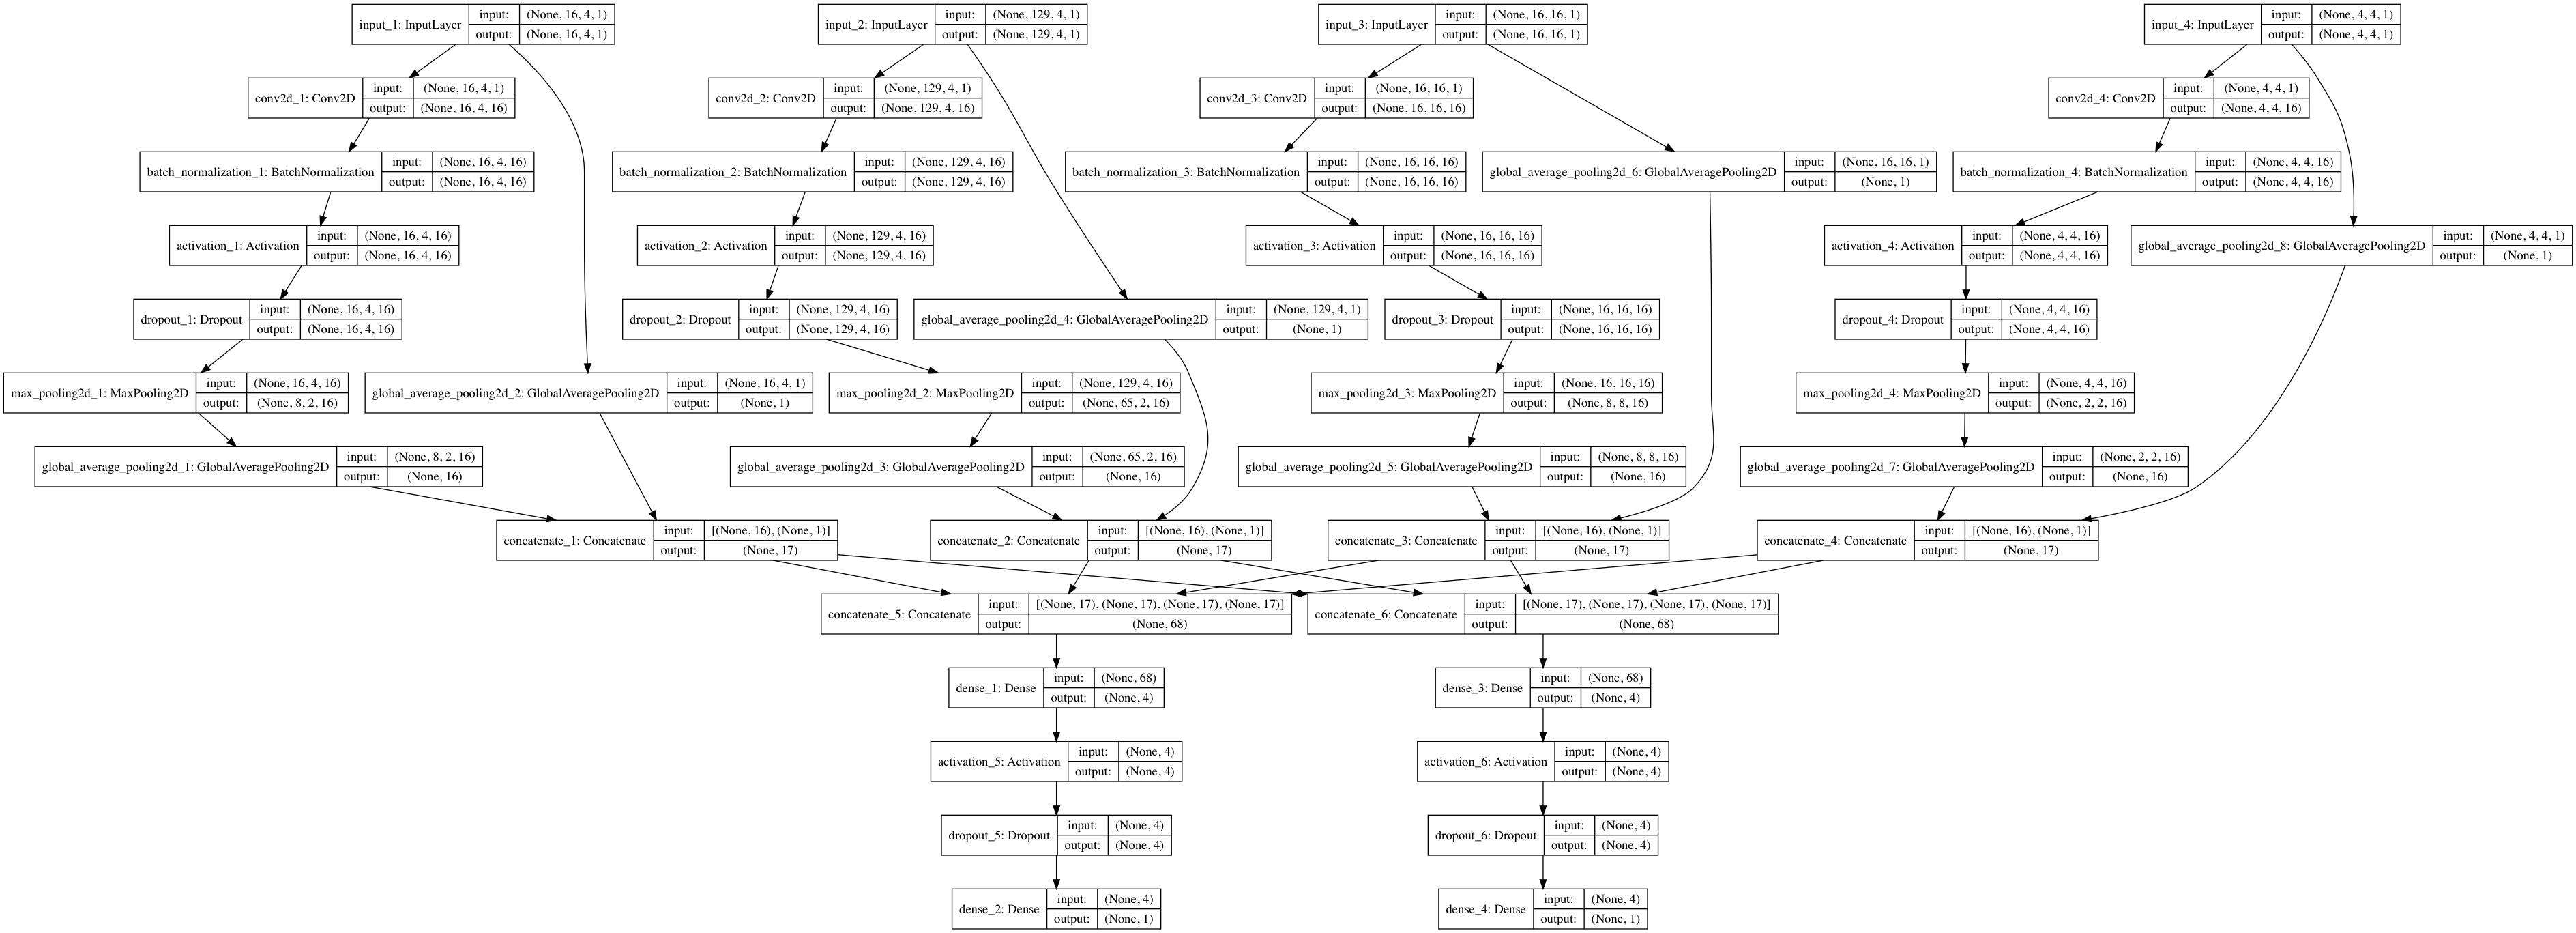

In [10]:
plot_model(cnn, to_file='figures/cnn.png', show_shapes=True)
Image(filename='figures/cnn.png')

Compile model.

In [11]:
cnn.compile(loss=["binary_crossentropy", "MSE"], optimizer="Adam")

Fit model.

In [12]:
cnn.fit(X_train, Y_train, batch_size=32, epochs=10, shuffle=True, validation_split=0.2)

Train on 41111 samples, validate on 10278 samples
Epoch 1/10
41111/41111 [==============================] - 30s 738us/step - loss: 273.9927 - dense_2_loss: 0.4402 - dense_4_loss: 273.5525 - val_loss: 104.6129 - val_dense_2_loss: 0.3115 - val_dense_4_loss: 104.3014
Epoch 2/10
41111/41111 [==============================] - 28s 685us/step - loss: 149.1028 - dense_2_loss: 0.2851 - dense_4_loss: 148.8177 - val_loss: 56.6203 - val_dense_2_loss: 0.2251 - val_dense_4_loss: 56.3952
Epoch 3/10
41111/41111 [==============================] - 27s 668us/step - loss: 136.5217 - dense_2_loss: 0.2357 - dense_4_loss: 136.2861 - val_loss: 53.9316 - val_dense_2_loss: 0.1940 - val_dense_4_loss: 53.7376
Epoch 4/10
41111/41111 [==============================] - 32s 767us/step - loss: 128.0849 - dense_2_loss: 0.2172 - dense_4_loss: 127.8677 - val_loss: 70.6580 - val_dense_2_loss: 0.1794 - val_dense_4_loss: 70.4786
Epoch 5/10
41111/41111 [==============================] - 32s 786us/step - loss: 120.3333 - dens

Evaluate model on testing dataset.

In [13]:
# Predict event label, and regressed quantities (e.g. ET)
y_pred, e_pred = cnn.predict(X_test, batch_size=32)

# Conform to shape of target arrays
y_pred = y_pred.flatten()
e_pred = e_pred.flatten()

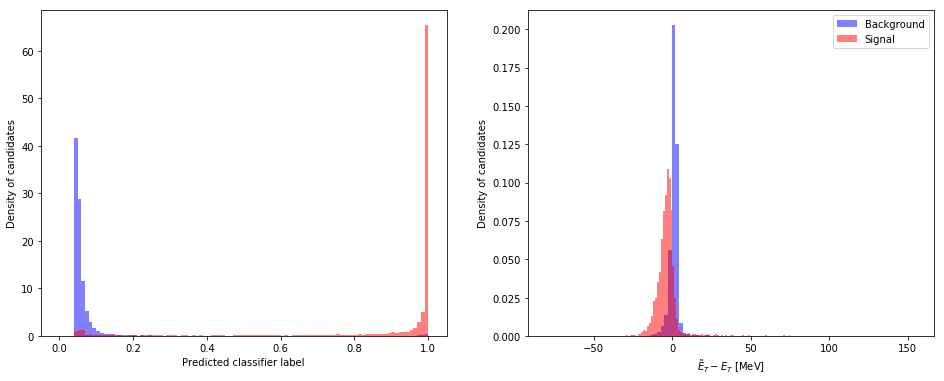

In [14]:
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(16,6))
bins = np.linspace(0, 1, 100 + 1, endpoint=True)

ax[0].hist(y_pred[Y_test[0] == 0], bins=bins, normed=True, alpha=0.5, color='blue', label='Background')
ax[0].hist(y_pred[Y_test[0] == 1], bins=bins, normed=True, alpha=0.5, color='red',  label='Signal')
ax[0].set_xlabel('Predicted classifier label')
ax[0].set_ylabel('Density of candidates')

ax[1].hist((e_pred - Y_test[1])[Y_test[0] == 0], bins=100, normed='True', alpha=0.5, color='blue', label='Background')
ax[1].hist((e_pred - Y_test[1])[Y_test[0] == 1], bins=100, normed='True', alpha=0.5, color='red',  label='Signal')
ax[1].set_xlabel(r'$\tilde{E}_{T} - E_{T}$ [MeV]')
ax[1].set_ylabel('Density of candidates')

plt.legend()
plt.show()